## Principal Component Analysis (PCA) — Unsupervised Dimensionality Reduction

We’ll build an unsupervised PCA pipeline:
	•	Data Exploration: load & inspect a multivariate dataset
	•	Preprocessing: train/test split, standardization
	•	Modeling: PCA from scratch (SVD) and with scikit-learn
	•	Evaluation: explained variance (scree), cumulative EVR, 2D visualization, loadings, and reconstruction error vs. number of components

Concept. PCA finds orthogonal directions (principal components) that maximize variance.
Objective. Minimize reconstruction error (equivalently, maximize retained variance) in a lower-dimensional subspace.
Key hyperparameters. n_components (int, float like 0.95 for variance threshold, or None), svd_solver, whiten.

## Setup

In [1]:
# Imports & reproducibility
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Optional, Tuple, Dict, List
from IPython.display import display

# sklearn utilities
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Optional viz
try:
    import seaborn as sns
except Exception:
    sns = None

np.random.seed(42)
plt.rcParams["figure.figsize"] = (7.2, 4.4)
plt.rcParams["axes.grid"] = True

## Data Exploration

We’ll use Wine (13 features). Labels are only for visualization; PCA is unsupervised.

In [2]:
wine = load_wine(as_frame=True)
X: pd.DataFrame = wine.data.copy()
y: pd.Series = pd.Series(wine.target, name="class")
feature_names = X.columns.tolist()

print("Shape:", X.shape)
display(X.head())
display(X.describe())

print("\nClass counts (for visualization only):")
display(y.value_counts().sort_index())

Shape: (178, 13)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000



Class counts (for visualization only):


class
0    59
1    71
2    48
Name: count, dtype: int64

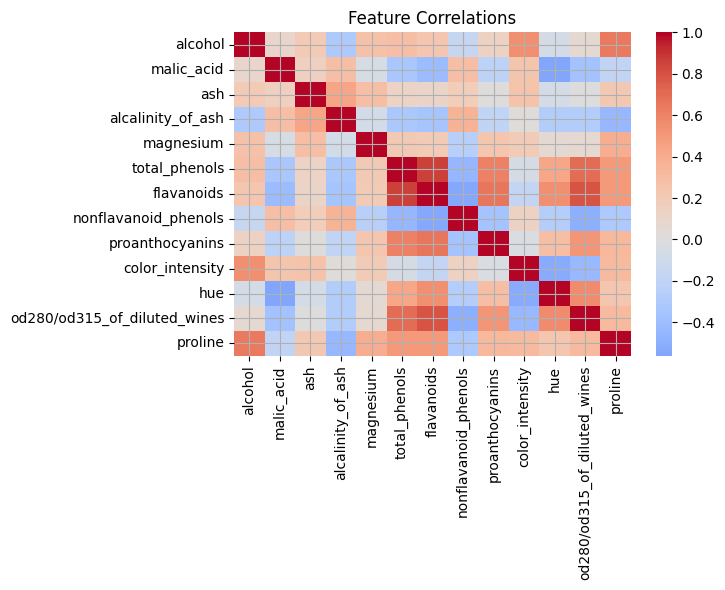

In [3]:
# Quick correlation heatmap
if sns is not None:
    plt.figure(figsize=(7.5, 6))
    sns.heatmap(X.corr(numeric_only=True), cmap="coolwarm", center=0)
    plt.title("Feature Correlations")
    plt.tight_layout(); plt.show()
else:
    print("Seaborn not installed; skipping heatmap.")

## Preprocessing
	•	Train/test split (so we can report reconstruction error on held-out data)
	•	Standardize features — PCA is scale-sensitive

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)

print("Train:", Xtr.shape, " Test:", Xte.shape)

Train: (133, 13)  Test: (45, 13)


## Modeling

We’ll compute PCA in two ways:
	1.	From scratch (SVD) on standardized data
	2.	scikit-learn PCA with full components, and with n_components=0.95 (retain 95% variance)

In [5]:
# From-scratch PCA via SVD 
def pca_svd(X_std: np.ndarray) -> Dict[str, np.ndarray]:
    """
    X_std: standardized data (n_samples x n_features), mean ~0, var ~1 per feature.
    Returns dict with components, singular values, explained variance & ratio.
    """
    n, d = X_std.shape
    # SVD on centered data
    U, S, Vt = np.linalg.svd(X_std, full_matrices=False)
    # Components (principal axes): columns of V (here rows of Vt)
    components = Vt  # shape (d, d)
    # Explained variance of each PC: S^2/(n-1)
    exp_var = (S**2) / (n - 1)
    exp_var_ratio = exp_var / exp_var.sum()
    return {"components": components, "S": S, "explained_variance": exp_var, "explained_variance_ratio": exp_var_ratio}

svd_out = pca_svd(Xtr)
evr_scratch = svd_out["explained_variance_ratio"]
components_scratch = svd_out["components"]  # (d, d)

print("Scratch PCA: first 5 explained variance ratios:")
print(np.round(evr_scratch[:5], 4))

Scratch PCA: first 5 explained variance ratios:
[0.3575 0.1921 0.1085 0.0742 0.0694]


In [6]:
#  scikit-learn PCA (full) 
pca_full = PCA(n_components=None, svd_solver="full", random_state=42)
pca_full.fit(Xtr)

print("sklearn PCA: first 5 explained variance ratios:")
print(np.round(pca_full.explained_variance_ratio_[:5], 4))

# Keep enough components to retain 95% of variance
pca_95 = PCA(n_components=0.95, svd_solver="full", random_state=42).fit(Xtr)
print("n_components for 95% variance:", pca_95.n_components_)

sklearn PCA: first 5 explained variance ratios:
[0.3575 0.1921 0.1085 0.0742 0.0694]
n_components for 95% variance: 10


## Evaluation

We’ll visualize explained variance (scree), cumulative EVR, 2D scatter in PC space, loadings (feature contributions), and reconstruction error vs. k.

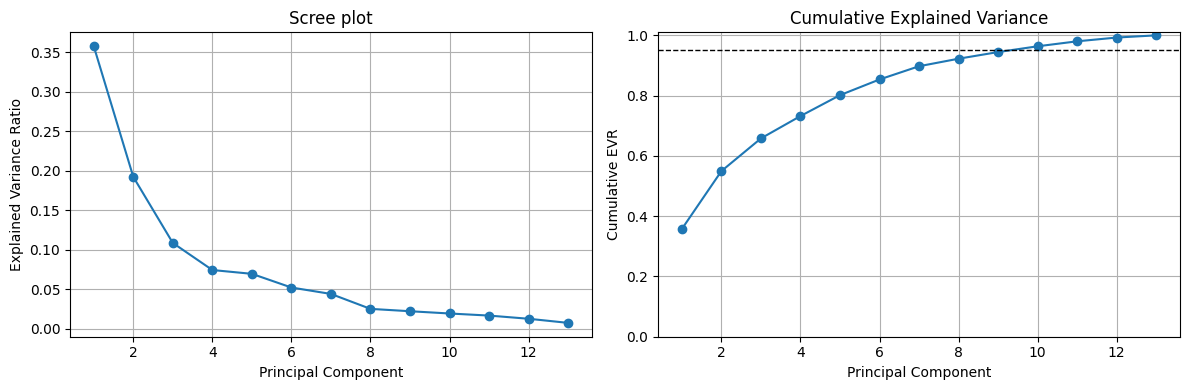

In [7]:
# Scree & cumulative plots (sklearn PCA)
evr = pca_full.explained_variance_ratio_
cum_evr = np.cumsum(evr)
k = np.arange(1, len(evr) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(k, evr, marker="o")
ax[0].set_title("Scree plot")
ax[0].set_xlabel("Principal Component")
ax[0].set_ylabel("Explained Variance Ratio")

ax[1].plot(k, cum_evr, marker="o")
ax[1].axhline(0.95, linestyle="--", color="k", linewidth=1)
ax[1].set_ylim(0, 1.01)
ax[1].set_title("Cumulative Explained Variance")
ax[1].set_xlabel("Principal Component")
ax[1].set_ylabel("Cumulative EVR")
plt.tight_layout(); plt.show()

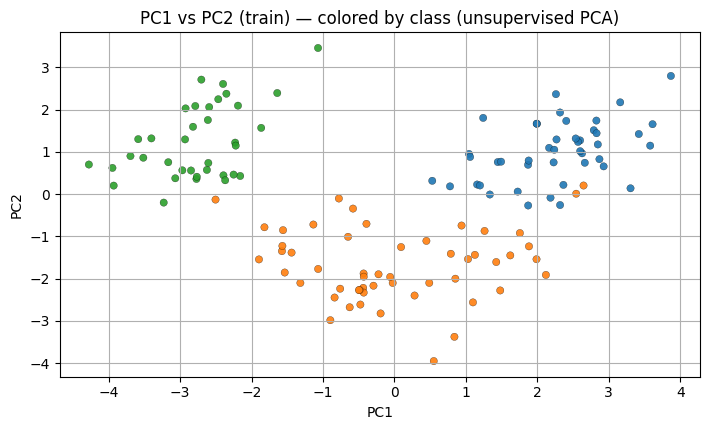

In [8]:
# 2D projection (PC1 vs PC2), colored by class (for visualization only)
Z_train = pca_full.transform(Xtr)[:, :2]
colors = plt.get_cmap("tab10")(y_train.to_numpy() % 10)

plt.scatter(Z_train[:, 0], Z_train[:, 1], c=colors, s=28, edgecolor="k", linewidths=0.2, alpha=0.9)
plt.title("PC1 vs PC2 (train) — colored by class (unsupervised PCA)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.show()

,PC1,PC2
flavanoids,0.427807,-0.001877
total_phenols,0.392694,0.069563
od280/od315_of_diluted_wines,0.381598,-0.171476
proanthocyanins,0.310834,0.002984
hue,0.303514,-0.286818
proline,0.290557,0.367551
alcohol,0.154343,0.485829
magnesium,0.138307,0.293692


,PC1,PC2
color_intensity,-0.093892,0.525169
alcohol,0.154343,0.485829
proline,0.290557,0.367551
ash,-0.010167,0.332664
magnesium,0.138307,0.293692
malic_acid,-0.237366,0.197082
total_phenols,0.392694,0.069563
nonflavanoid_phenols,-0.281837,0.013360


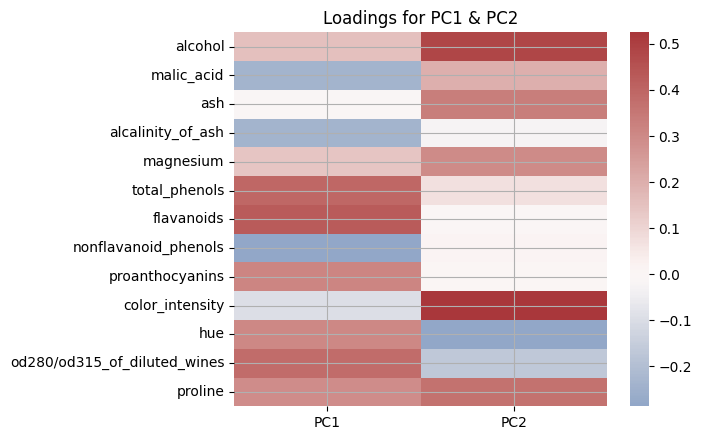

In [9]:
# Loadings (feature contributions) for PC1 and PC2
loadings = pd.DataFrame(
    pca_full.components_[:2].T,
    index=feature_names,
    columns=["PC1", "PC2"]
)
display(loadings.sort_values("PC1", ascending=False).head(8))
display(loadings.sort_values("PC2", ascending=False).head(8))

if sns is not None:
    plt.figure(figsize=(7.2, 4.5))
    sns.heatmap(loadings, annot=False, cmap="vlag", center=0)
    plt.title("Loadings for PC1 & PC2")
    plt.tight_layout(); plt.show()

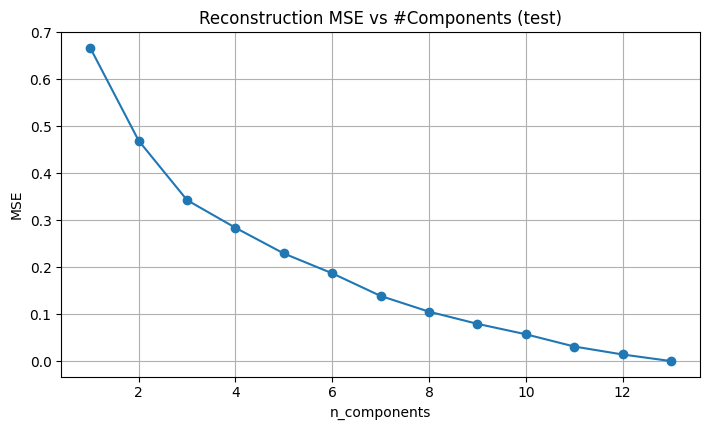

MSE at 2 comps: 0.4693  | MSE at 95%-variance k: 0.0571


In [10]:
# Reconstruction & error vs number of components (test set)
def reconstruct(pca_model: PCA, X_std: np.ndarray, ncomp: int) -> np.ndarray:
    """
    Reconstruct X_std using the first ncomp components from a fitted PCA.
    Works with a full PCA fit; uses model's mean to invert transform.
    """
    # Temporarily limit components
    comps = pca_model.components_.copy()
    pca_model.components_ = comps[:ncomp, :]
    Z = pca_model.transform(X_std)
    Xr = pca_model.inverse_transform(Z)
    # Restore
    pca_model.components_ = comps
    return Xr

ks = list(range(1, Xtr.shape[1] + 1))
errs = []
for ncomp in ks:
    Xte_rec = reconstruct(pca_full, Xte, ncomp)
    mse = mean_squared_error(Xte, Xte_rec)
    errs.append(mse)

plt.plot(ks, errs, marker="o")
plt.title("Reconstruction MSE vs #Components (test)")
plt.xlabel("n_components"); plt.ylabel("MSE")
plt.tight_layout(); plt.show()

print("MSE at 2 comps:", round(errs[1], 4), " | MSE at 95%-variance k:", round(errs[pca_95.n_components_-1], 4))

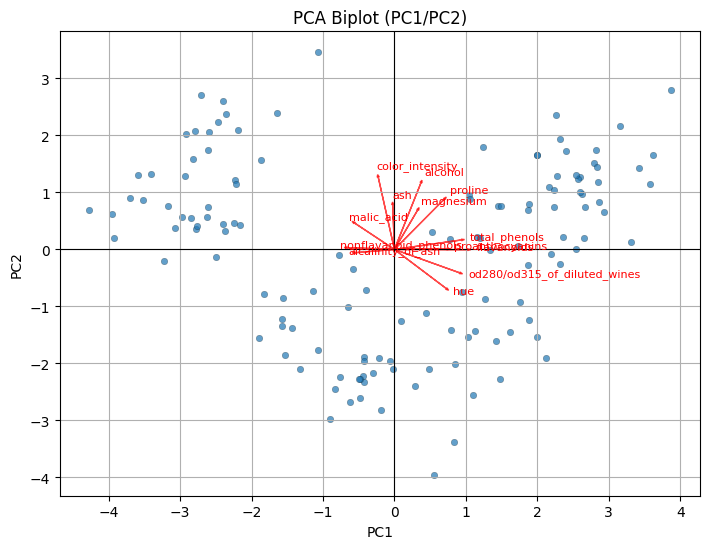

In [11]:
def biplot(scores: np.ndarray, components: np.ndarray, feature_names: List[str], scale_scores: float = 1.0, scale_vectors: float = 1.0, title: str = "Biplot"):
    """
    scores: (n_samples, 2) transformed data (PC1, PC2)
    components: (2, d) first two principal axes (sklearn's pca.components_[:2])
    """
    x = scores[:, 0] * scale_scores
    y = scores[:, 1] * scale_scores
    plt.figure(figsize=(7.2, 5.6))
    plt.scatter(x, y, s=22, alpha=0.7, edgecolor="k", linewidths=0.2)
    for i, fname in enumerate(feature_names):
        vx = components[0, i] * scale_vectors
        vy = components[1, i] * scale_vectors
        plt.arrow(0, 0, vx, vy, color="red", alpha=0.7, head_width=0.03, length_includes_head=True)
        plt.text(vx * 1.08, vy * 1.08, fname, color="red", fontsize=8)
    plt.axhline(0, color="k", lw=0.8); plt.axvline(0, color="k", lw=0.8)
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.title(title)
    plt.tight_layout(); plt.show()

# Use a modest scaling so arrows are visible
biplot(Z_train, pca_full.components_[:2], feature_names, scale_scores=1.0, scale_vectors=2.5, title="PCA Biplot (PC1/PC2)")

## Key Takeaways
	•	PCA rotates/orthogonalizes features to directions of maximum variance.
	•	Choose n_components by cumulative EVR (e.g., 0.95) or by inspecting reconstruction error.
	•	Always standardize when feature scales differ.
	•	Loadings indicate how original features contribute to each PC; biplots help interpret structure.
	•	PCA is linear; for nonlinear manifolds consider Kernel PCA, Isomap, t-SNE, or UMAP.